In [1]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import mw_protocol.plotting as plotting
import mw_protocol.saving as saving
import mw_protocol.spreading as spreading
import mw_protocol.toolbox as tb
import seaborn as sns
import cProfile

In [2]:
sns.set(rc={'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
# To change to your personal directory
script_folder = "/nfs/see-fs-01_users/eeymr/work/scripts/mw_protocol/"

# Demonstration saving algorithm

**Objective** : Ploting tools to the visualise the discharge datasets.
- Plot discharge time series.
- Scater plots of routed discharge files.

## Scatter plots

In [4]:
ds_routed = xr.open_dataset(f"{script_folder}/outputs/sample_routed_discharge.nc", decode_times=False)
ds_routed

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 5)
Coordinates:
  * t          (t) int64 -26000 -25900 -25800 -25700 -25600
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:                ROUTED MELTWATER DISCHARGE
    start_year:           -26000
    end_year:             -25600
    step:                 100
    mode_lon:             double
    mode_shape:           cross
    running_mean_period:  0
    ice_sheet:            GLAC-1D
    waterfix:             None
    history:              Created 2022-12-09 14:46:28.407982 by Yvan Romé

In [5]:
# Land sea mask
ds_lsm = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
lon_lsm, lat_lsm = ds_lsm.longitude.values, ds_lsm.latitude.values
lon_lsm_b, lat_lsm_b = tb.create_coordinate_edges(lon_lsm), lat_lsm
lsm = ds_lsm.lsm.values

/nfs/see-fs-01_users/eeymr/.conda/envs/eeymr/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


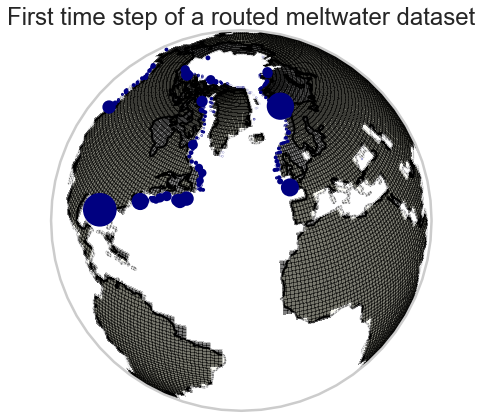

In [6]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="binary", alpha=0.5)

x,y,s = plotting.scatter_mask(ds_routed.discharge[0].values)
axMap.scatter(lon_lsm[x], lat_lsm[y], transform=ccrs.PlateCarree(), s=s*10, color="navy")
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Remove/add Waterfix

In [4]:
ds_lsm = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
ds_wfix = xr.open_dataset(f"{script_folder}/data/temev.qrparm.waterfix.nc")

ds_final = xr.open_dataset(f"{script_folder}/outputs/sample_final_discharge.nc", decode_times=False)
ds_final_wfix = saving.ancil_to_discharge(ds_final)
ds_final_nowfix = plotting.remove_waterfix(ds_final_wfix, ds_wfix)
ds_final_loop = plotting.add_waterfix(ds_final_nowfix, ds_wfix, wfix_name="GLAC-1D")
ds_final

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 144, longitude: 288, t: 5)
Coordinates:
  * t          (t) int64 -26000 -25900 -25800 -25700 -25600
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * depth      (depth) float64 5.0
Data variables:
    discharge  (t, depth, latitude, longitude) float64 ...
Attributes:
    title:                Spread meltwater + waterfix mask for transient last...
    start_year:           -26000
    end_year:             -25600
    step:                 100
    mode_lon:             double
    mode_shape:           cross
    running_mean_period:  0
    ice_sheet:            GLAC-1D
    waterfix:             GLAC_1D
    history:              Created on 12/12/2022 16:43:13 by Yvan Malo Romé

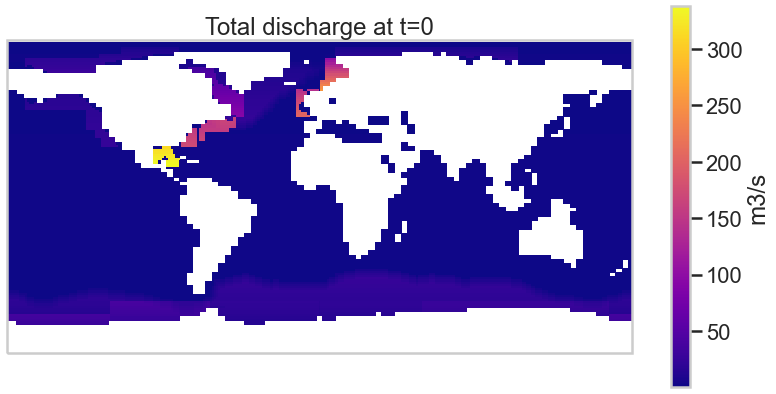

In [7]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(ds_final.longitude, ds_final.latitude, tb.masking(ds_final_wfix.discharge.isel(t=0).values, ds_lsm.lsm.values),
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("Total discharge at t=0")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

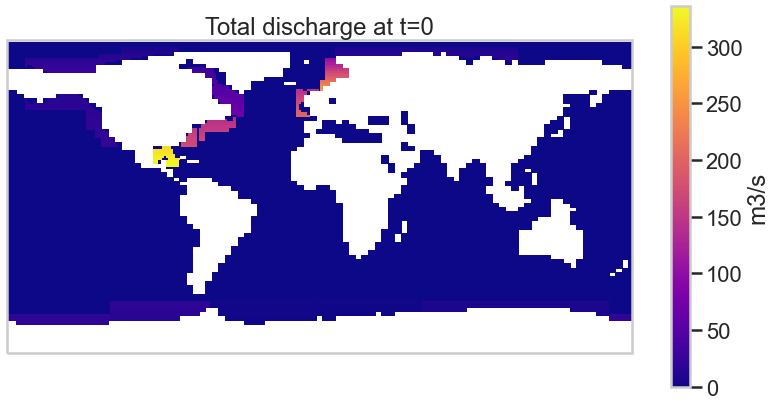

In [9]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(ds_final.longitude, ds_final.latitude, tb.masking(ds_final_nowfix.isel(t=0).discharge.values, ds_lsm.lsm.values),
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("Total discharge at t=0")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

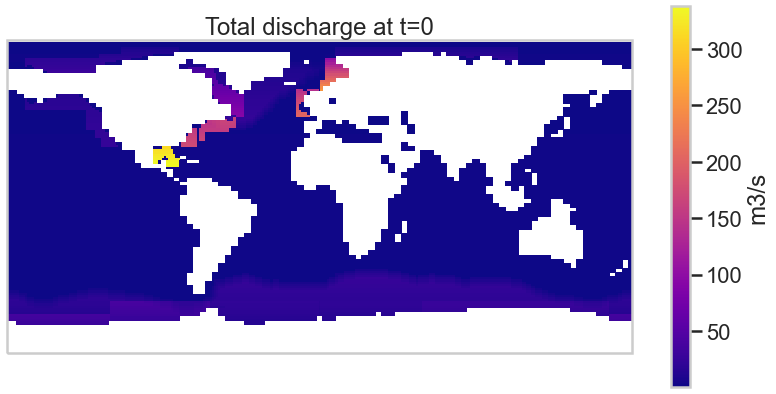

In [10]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

# Masking method is necessary to transform 0 to nan.
cmap = axMap.pcolormesh(ds_final.longitude, ds_final.latitude, tb.masking(ds_final_loop.isel(t=0).discharge.values, ds_lsm.lsm.values),
                        cmap='plasma', transform=ccrs.PlateCarree())
axMap.set_global()
axMap.set_title("Total discharge at t=0")
figMap.colorbar(mappable=cmap, ax=axMap, label="m3/s")

## Discharge time serie plot

In [7]:
ds_spread = xr.open_dataset(f"{script_folder}/outputs/sample_spread_discharge.nc", decode_times=False)
ds_lsm = xr.open_dataset(f"{script_folder}/data/temev.qrparm.omask.nc")
ds_spread

<xarray.Dataset>
Dimensions:    (latitude: 144, longitude: 288, t: 5)
Coordinates:
  * t          (t) int64 -26000 -25900 -25800 -25700 -25600
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
  * longitude  (longitude) float32 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
Data variables:
    discharge  (t, latitude, longitude) float64 ...
Attributes:
    title:                SPREAD MELTWATER DISCHARGE
    start_year:           -26000
    end_year:             -25600
    step:                 100
    mode_lon:             double
    mode_shape:           cross
    running_mean_period:  0
    ice_sheet:            GLAC-1D
    waterfix:             GLAC-1D
    history:              Created 2022-11-30 14:35:04.568689 by Yvan Romé

In [8]:
# cProfile.run("plotting.create_discharge_ts(ds_spread, ds_lsm, details='low')")

In [9]:
fluxes_low = plotting.create_discharge_ts(ds_spread, ds_lsm, details='low')
fluxes_low

{'elwg': East Laurentide and West Greenland -> [0.05613365 0.07133241 0.09245804 0.09110024 0.0624493 ],
 'gin': GIN seas -> [0.02727235 0.02886513 0.02756682 0.02563703 0.02276493],
 'med': Mediterranean Sea -> [0.0004026  0.00040134 0.00040379 0.00040134 0.0004031 ],
 'arc': Arctic -> [0.01127942 0.01403656 0.01923488 0.01971101 0.01498639],
 'so': Southern Ocean -> [0.04275215 0.0395091  0.03871835 0.03625063 0.0402262 ],
 'pac': Pacific -> [0.00538996 0.00770992 0.01156468 0.01453234 0.00808604],
 'tot': Total -> [0.14323014 0.16185446 0.18994656 0.18763259 0.14891597]}

Text(0.5, 1.0, 'Discharge time series')

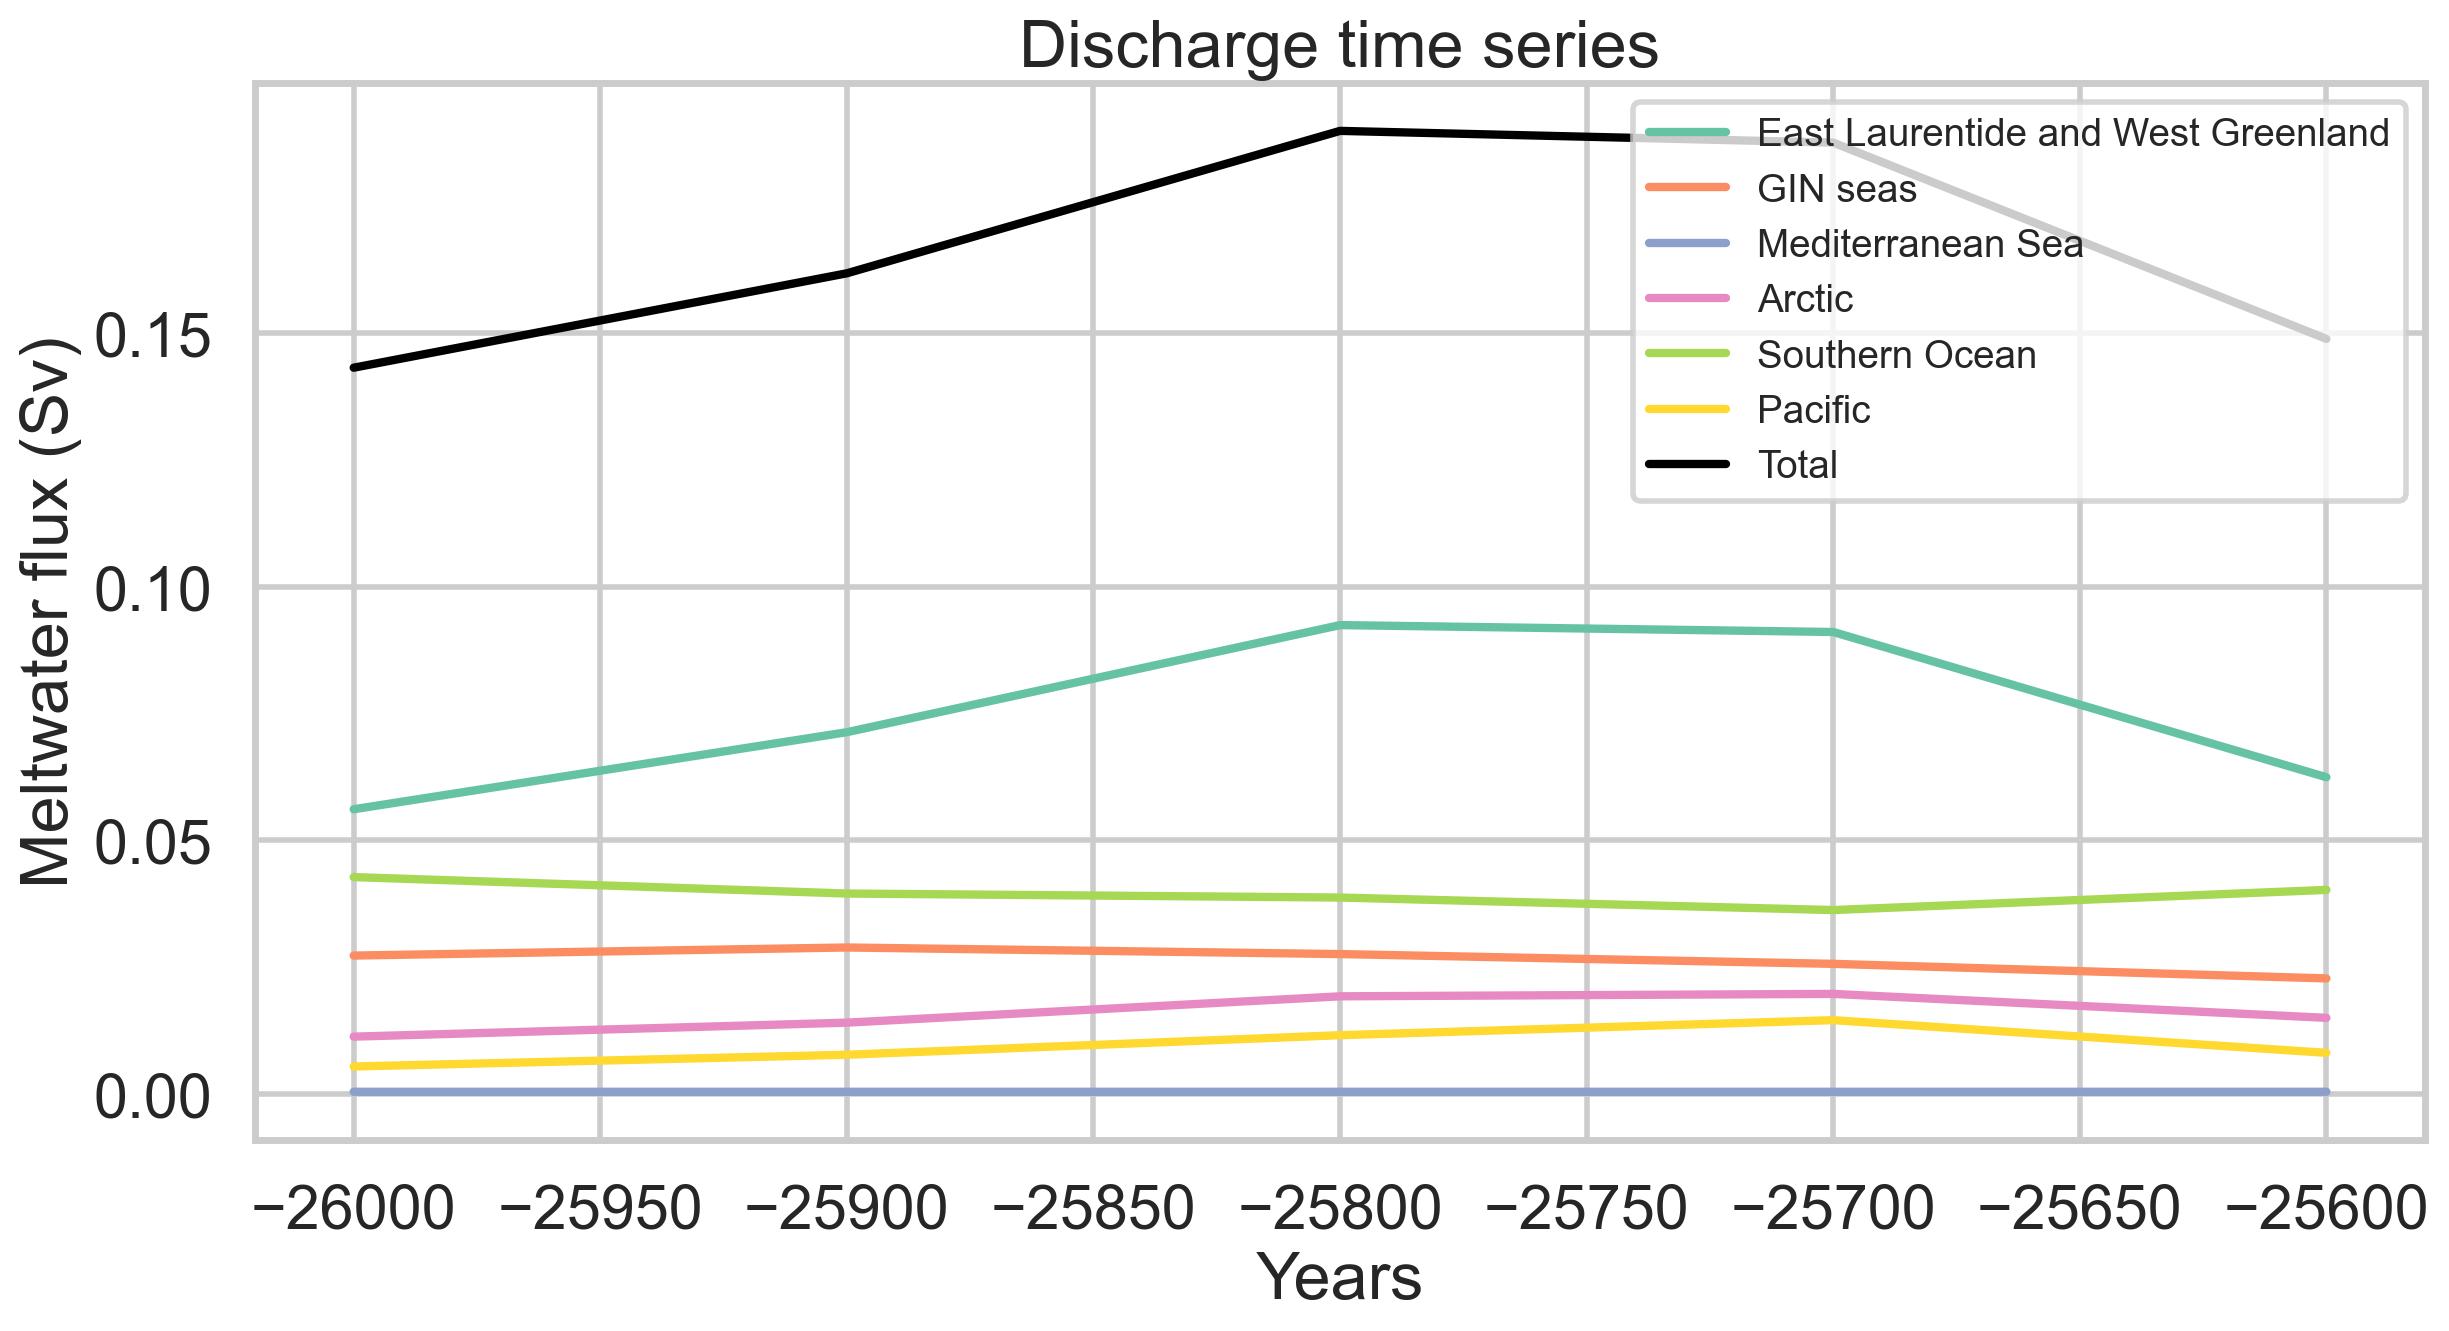

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7), dpi=200)

t = ds_spread.t.values

c_list = iter(plt.cm.Set2.colors)
colors_region = {key: next(c_list) for key in fluxes_low.keys()}
colors_region['tot'] = 'black'

for flux in fluxes_low:
    ax.plot(t, fluxes_low[flux].value, label=fluxes_low[flux].name, color=colors_region[flux], linestyle="-")

ax.legend(loc="upper right", fontsize='xx-small')

ax.set_ylabel("Meltwater flux (Sv)")
ax.ticklabel_format(style="sci")
ax.set_xlabel("Years")
ax.set_title("Discharge time series")

In [11]:
fluxes_medium = plotting.create_discharge_ts(ds_spread, ds_lsm, details='medium')
fluxes_medium

{'nea': East Laurentide and West Greenland -> [0.05613365 0.07133241 0.09245804 0.09110024 0.0624493 ],
 'egi': East Greenland Iceland -> [0.00312252 0.00312733 0.00311585 0.00314265 0.00320034],
 'nsbi': Nordic Seas -> [0.02414984 0.02573779 0.02445097 0.02249438 0.0195646 ],
 'med': Mediterranean Sea -> [0.0004026  0.00040134 0.00040379 0.00040134 0.0004031 ],
 'larc': Laurentide Arctic -> [0.00693224 0.01011667 0.01478019 0.01514393 0.01035025],
 'garc': Greenland Arctic -> [0.00018141 0.00017965 0.00017887 0.00017752 0.0001872 ],
 'earc': Eurasian Arctic -> [0.00416577 0.00374024 0.00427582 0.00438955 0.00444895],
 'so': Southern Ocean -> [0.04275215 0.0395091  0.03871835 0.03625063 0.0402262 ],
 'pac': Pacific -> [0.00538996 0.00770992 0.01156468 0.01453234 0.00808604],
 'tot': Total -> [0.14323014 0.16185446 0.18994656 0.18763259 0.14891597]}

Text(0.5, 1.0, 'Discharge time series')

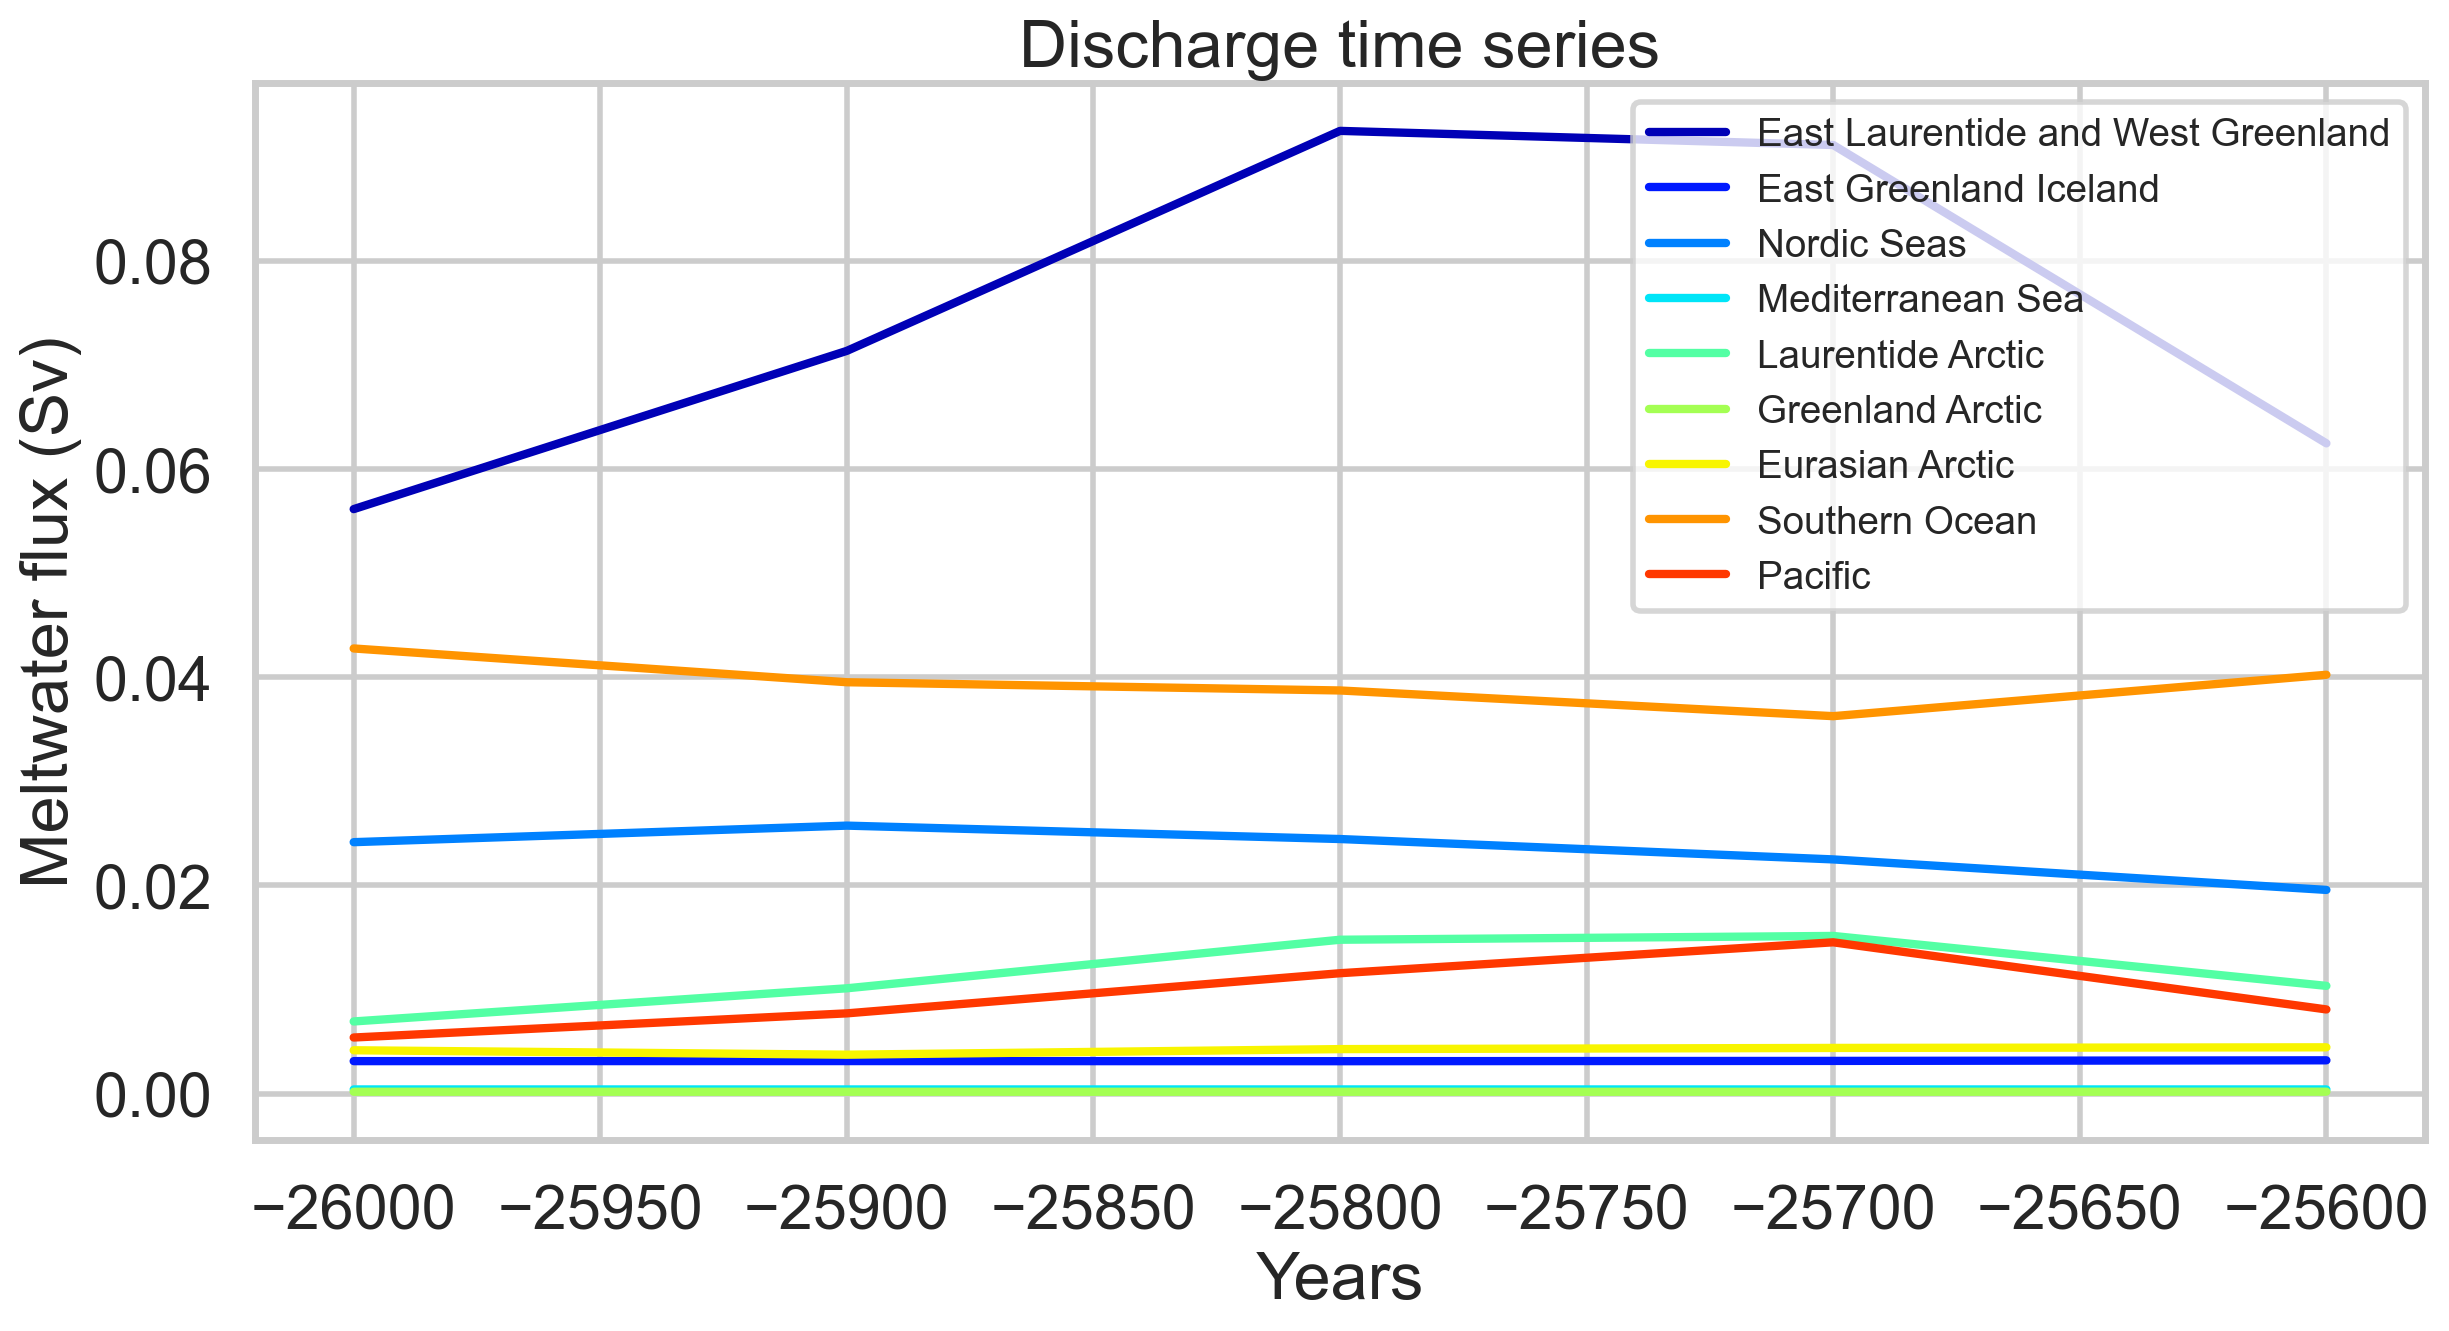

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7), dpi=200)

t = ds_spread.t.values

c_list = iter(plt.cm.jet(np.linspace(0.05, 0.95, len(fluxes_medium))))
colors_region = {key: next(c_list) for key in fluxes_medium.keys()}
colors_region['tot'] = 'black'

for flux in {key: fluxes_medium[key] for key in fluxes_medium if key != 'tot'}:
    ax.plot(t, fluxes_medium[flux].value, label=fluxes_medium[flux].name, color=colors_region[flux], linestyle="-")

ax.legend(loc="upper right", fontsize='xx-small')

ax.set_ylabel("Meltwater flux (Sv)")
ax.ticklabel_format(style="sci")
ax.set_xlabel("Years")
ax.set_title("Discharge time series")

In [13]:
fluxes_high = plotting.create_discharge_ts(ds_spread, ds_lsm, details='high')
fluxes_high

{'eus': US East coast -> [0.02049885 0.02014863 0.02516878 0.02759404 0.01841298],
 'gom': Gulf of Mexico -> [0.02355681 0.03617997 0.04702815 0.04739568 0.0313978 ],
 'lsbb': Labrador Sea & Baffin Bay -> [0.01207798 0.01500382 0.02026111 0.01611052 0.01263852],
 'atgi': Altantic Greenland Iceland -> [0.00178694 0.00178554 0.00178543 0.00181393 0.00187071],
 'egi': East Greenland Iceland -> [0.00105081 0.00105703 0.00104565 0.00104396 0.00104486],
 'eic': East Iceland -> [0.00012002 0.00012002 0.00012002 0.00012002 0.00012002],
 'sic': South Iceland -> [0.00016475 0.00016475 0.00016475 0.00016475 0.00016475],
 'ukat': UK Atlantic -> [0.00764451 0.00858672 0.00737609 0.00662366 0.0048155 ],
 'egin': Eurasian GIN -> [0.01650533 0.01715107 0.01707488 0.01587072 0.0147491 ],
 'med': Mediterranean Sea -> [0.0004026  0.00040134 0.00040379 0.00040134 0.0004031 ],
 'larc': Laurentide Arctic -> [0.00693224 0.01011667 0.01478019 0.01514393 0.01035025],
 'garc': Greenland Arctic -> [0.00018141 0.

Text(0.5, 1.0, 'Discharge time series')

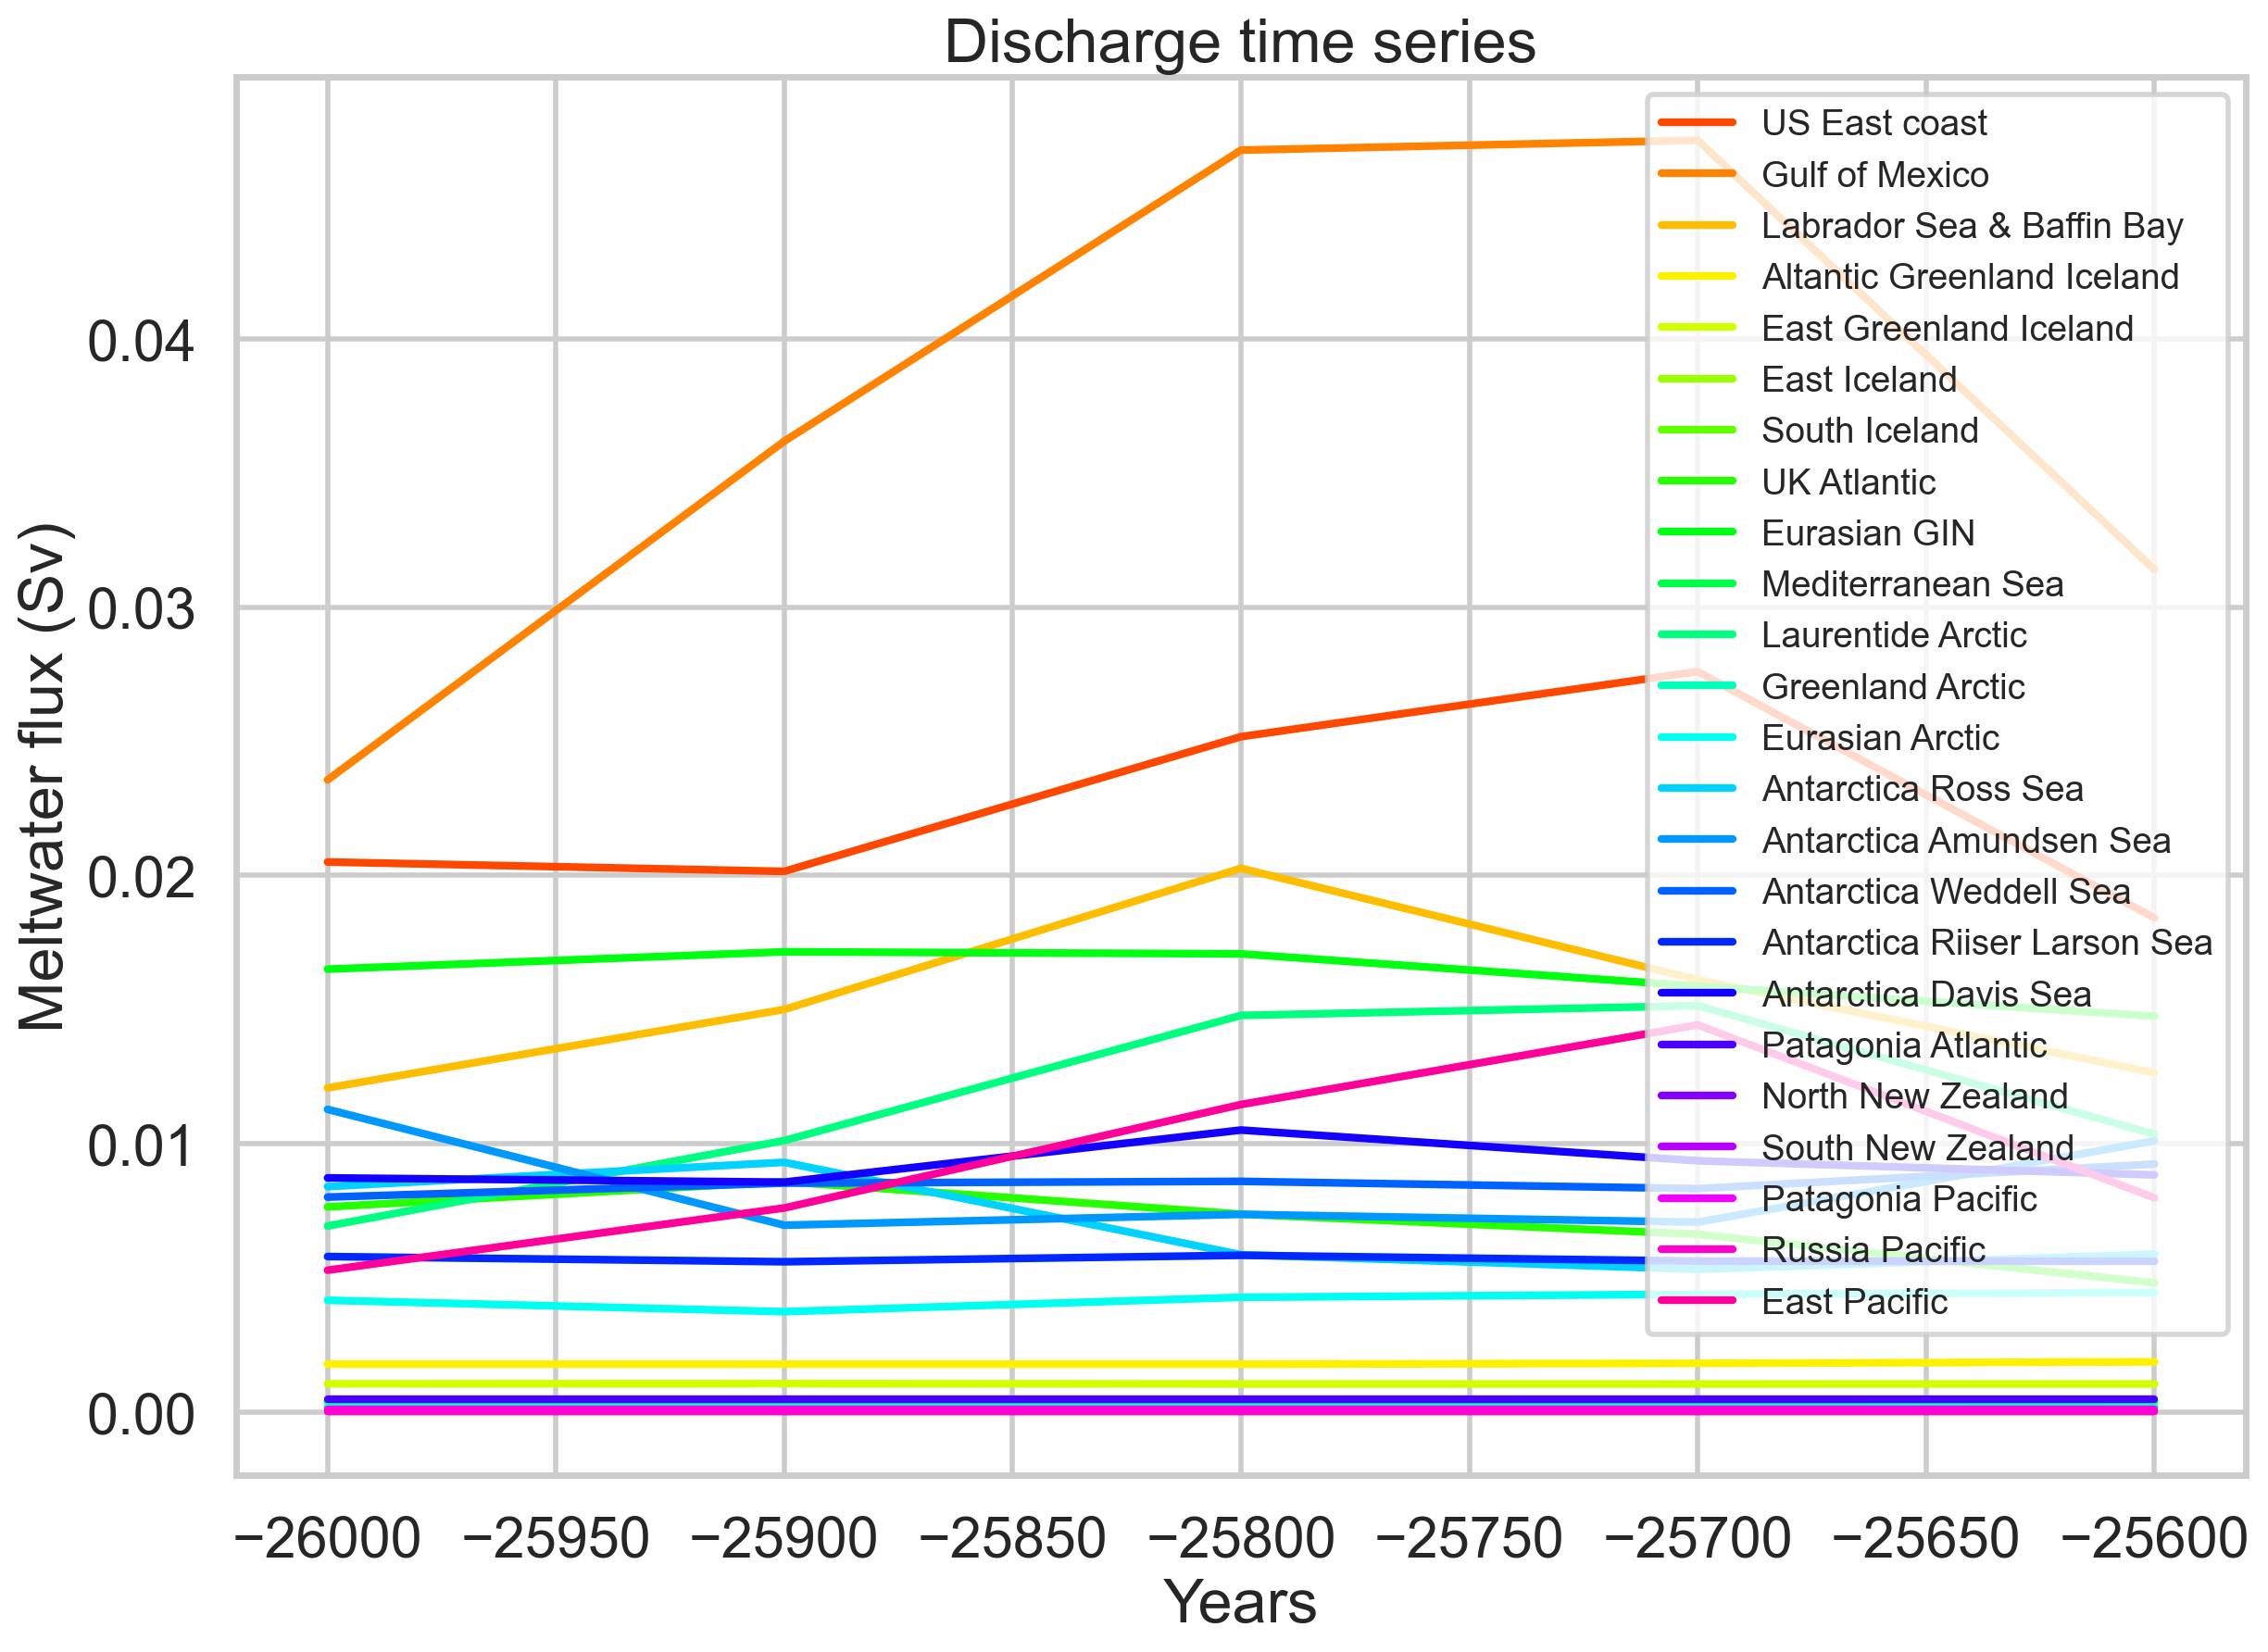

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 10), dpi=200)

t = ds_spread.t.values

c_list = iter(plt.cm.hsv(np.linspace(0.05, 0.95, len(fluxes_high))))
colors_region = {key: next(c_list) for key in fluxes_high.keys()}
colors_region['tot'] = 'black'

for flux in {key: fluxes_high[key] for key in fluxes_high if key != 'tot'}:
    ax.plot(t, fluxes_high[flux].value, label=fluxes_high[flux].name, color=colors_region[flux], linestyle="-")

ax.legend(loc="upper right", fontsize='xx-small')

ax.set_ylabel("Meltwater flux (Sv)")
ax.ticklabel_format(style="sci")
ax.set_xlabel("Years")
ax.set_title("Discharge time series")